In [73]:
import os
import re
import matplotlib

import imageio
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from sys import argv
from scipy.special import factorial
from scipy.stats import poisson
import seaborn as sns
from scipy.special import factorial, gammaln
plt.style.use('seaborn-darkgrid')

### Acomodamos la data
Creamos un diccionario con los nombres de las carpetas y el contenido de ellas. Luego buscamOs las carpetas que tienen trace names diferentes y las agrupamos en distintos diccionarios uno para cada trace names.

obs: Tambien hay carpetas que tienen archivos bkp, esos si son necesarios habria que tomarlos tambien.

In [76]:
files = {os.path.splitext(k)[0]: {} for k in os.listdir('data/rawData')}

for i,file in enumerate(os.listdir('data/rawData')):
    name=str(os.path.splitext(file)[0])
    f = open(f'data/rawData/{name}/rawdataEMCCD.dat').read().split()
    files[name]=f
# Busco las carpetas que tienen trace names diferentes y las agrupo en distintos
# diccionarios uno para cada trace names.

# Tambien hay carpetas que tienen archivos bkp, esos si son necesarios habria que tomarlos tambien.
l=[]
l1=[]
l2=[]
l3=[]
l4=[]

for i in files:
    if files[i][14]=="866'":
        l.append(int(i))
    elif files[i][13]=="'rsbAx'":
        l1.append(int(i))
    elif files[i][13]=="'rsbRad1'":
        l2.append(int(i))
    elif files[i][13]=="'rsbRad2'":
        l3.append(int(i))
    elif files[i][13]=="'carrier":
        l4.append(int(i))

l=sorted(l)
l1=sorted(l1)
l2=sorted(l2)
l3=sorted(l3)
l4=sorted(l4)
print("Las carpetas con trace names 'without 866' 'with 866 and 854' son:")
print(l)
print('--------------------')
print("Las carpetas con trace names 'rsbAx' 'bsbAx' son:")
print(l1)
print('--------------------')
print("Las carpetas con trace names 'rsbRad1' 'bsbRad1' son:")
print(l2)
print('--------------------')
print("Las carpetas con trace names 'rsbRad2' 'bsbRad2' son:")
print(l3)
print('--------------------')
print("Las carpetas con trace names 'carrier dopp cool' 'carrier SB cool' son:")
print(l4)

# Armo los diccionarios para cada trace name
w866={}
rsbAx={}
rsbRad1={}
rsbRad2={}
cdc={}

# Lleno los diccionarios con sus respectivos archivos
for i in l:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][46:]:
            flo.append(float(j))
        w866[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][46:]:
            flo.append(float(j))
        w866[str(i)]=np.transpose(flo)

for i in l1:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][42:]:
            flo.append(float(j))
        rsbAx[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][42:]:
            flo.append(float(j))
        rsbAx[str(i)]=np.transpose(flo)

for i in l2:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][42:]:
            flo.append(float(j))
        rsbRad1[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][42:]:
            flo.append(float(j))
        rsbRad1[str(i)]=np.transpose(flo)

for i in l3:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][42:]:
            flo.append(float(j))
        rsbRad2[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][42:]:
            flo.append(float(j))
        rsbRad2[str(i)]=np.transpose(flo)

for i in l4:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][46:]:
            flo.append(float(j))
        cdc[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][46:]:
            flo.append(float(j))
        cdc[str(i)]=np.transpose(flo)
        
# Arreglo los archivos de el diccionario file pero tomando desde el dato 46, me voy a comer alguno datos
# para algunos archivos

for i in files.keys():
    val=[]
    for j in files[i][46:]:
        val.append(float(j))
    files[i]=np.transpose(val)


Las carpetas con trace names 'without 866' 'with 866 and 854' son:
[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
--------------------
Las carpetas con trace names 'rsbAx' 'bsbAx' son:
[0, 4, 74, 75, 77, 78, 81, 82, 84, 85]
--------------------
Las carpetas con trace names 'rsbRad1' 'bsbRad1' son:
[1, 5]
--------------------
Las carpetas con trace names 'rsbRad2' 'bsbRad2' son:
[2, 6]
--------------------
Las carpetas con trace names 'carrier dopp cool' 'carrier SB cool' son:
[3, 7, 73, 76, 79, 80, 83]


### Hallando los paramteros $\lambda$
Los archivos estan cargados ahora en forma de arrays

In [77]:
def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return  poisson.pmf(k, lamb)

def poisson_(k, lamb,a,offy,offx,b):
    """poisson pdf, parameter lamb is the fit parameter"""
    return a*( (np.exp(-lamb) * lamb**(b*k+offx)) /factorial(b*k+offx) )+offy 

def poisson_approx(k, lamb,a,offy,offx,b):
    """poisson pdf, parameter lamb is the fit parameter"""
    return  a*(np.exp( (b*k+offx)*np.log(lamb)-lamb - gammaln *((b*k+offx) + 1)))+offy

def two_poisson(k, lamb,a,offy,offx,b, lamb2,a2,offy2,offx2,b2):
    sum_ =  (a*( (np.exp(-lamb) * lamb**(b*k+offx)) /factorial(b*k+offx) )+offy ) + (a2*( (np.exp(-lamb2) * lamb2**(b2*k+offx2)) /factorial(b2*k+offx2) )+offy2) 
    return sum_

In [80]:
dicts = [w866,rsbAx,rsbRad1,rsbRad2,cdc]

### Treshold de cada set de datos

<ipython-input-221-451cd4f64f03>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


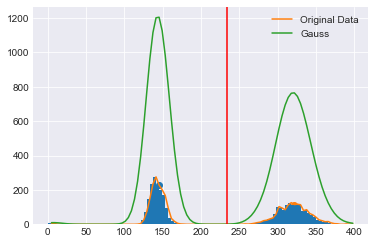

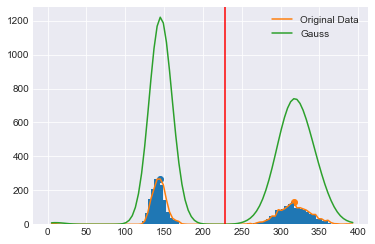

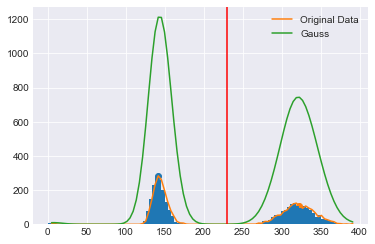

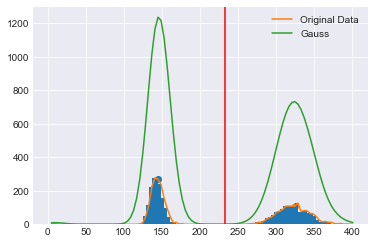

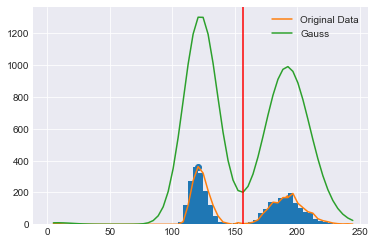

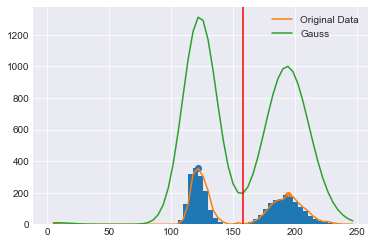

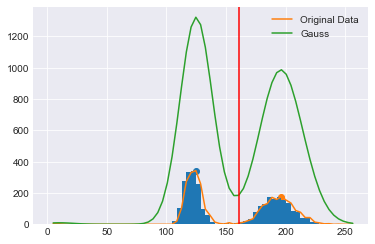

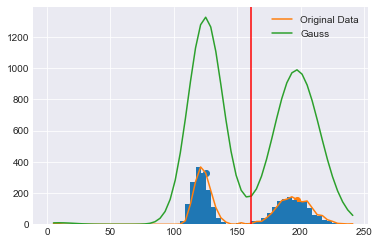

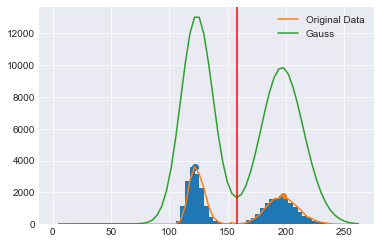

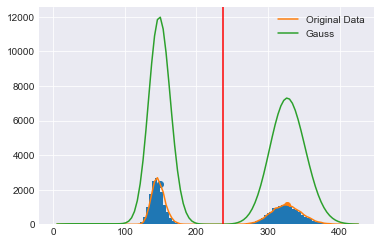

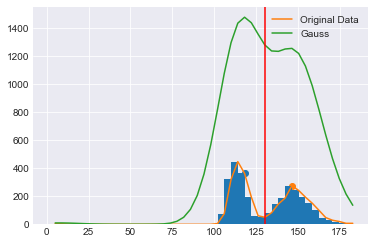

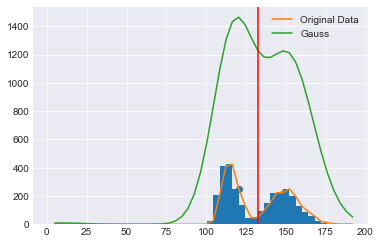

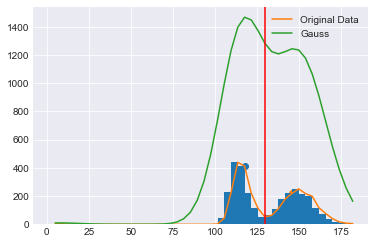

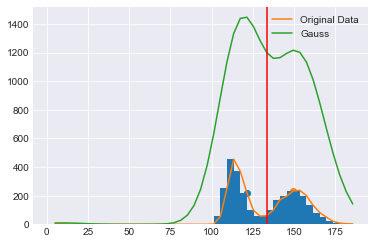

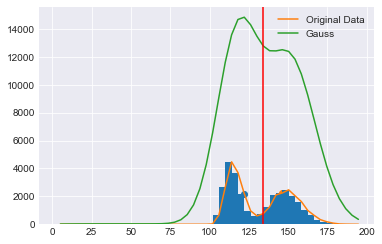

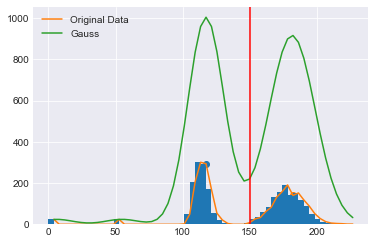

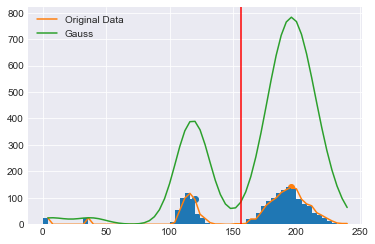

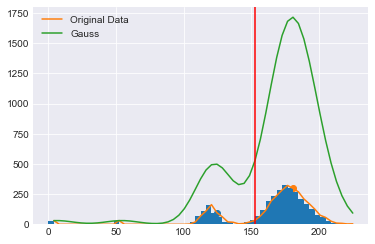

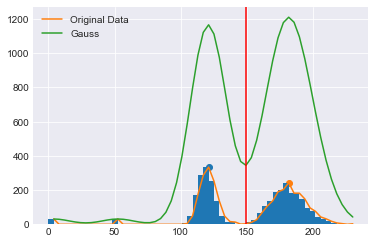

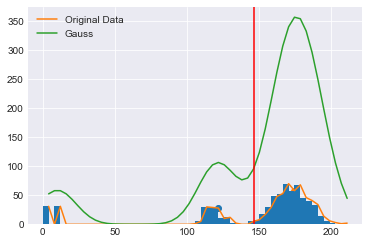

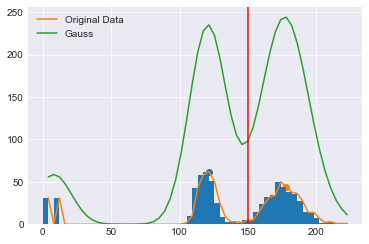

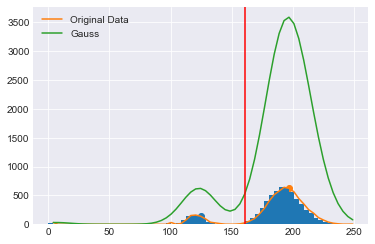

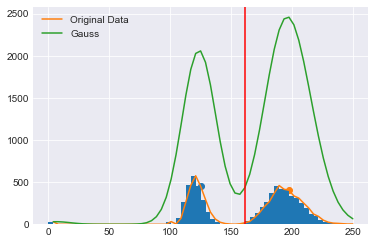

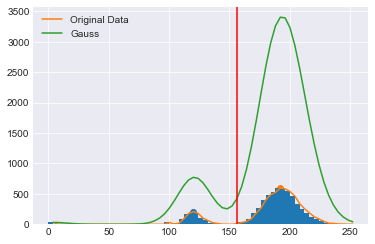

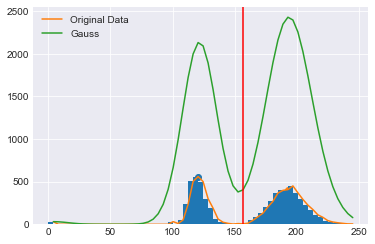

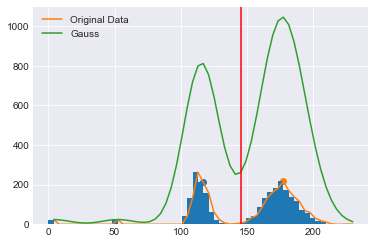

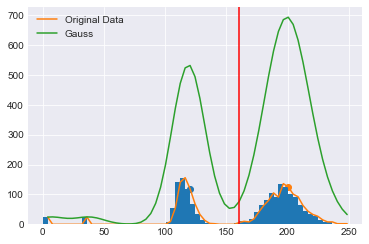

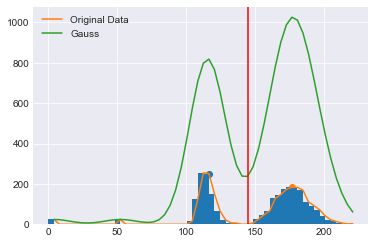

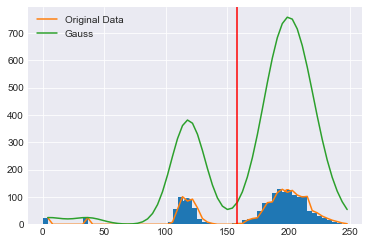

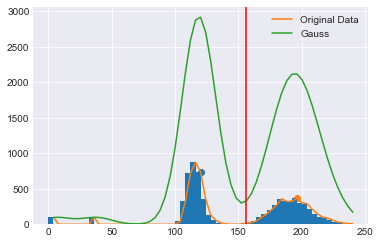

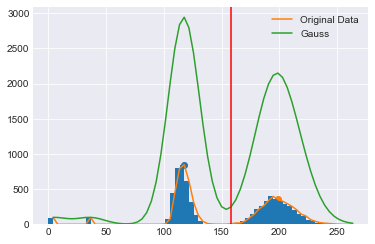

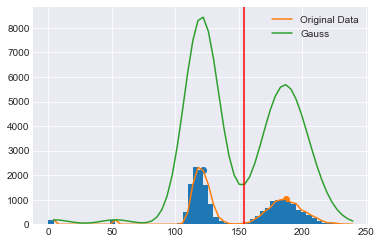

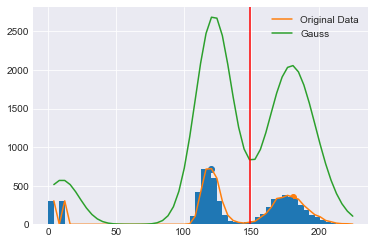

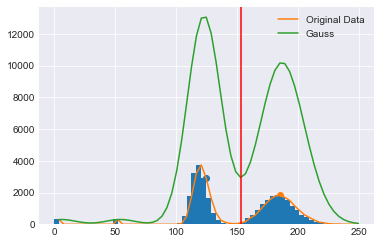

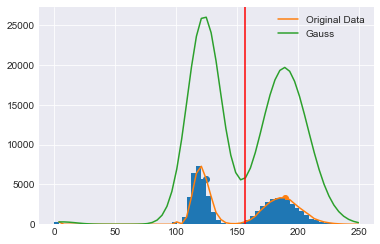

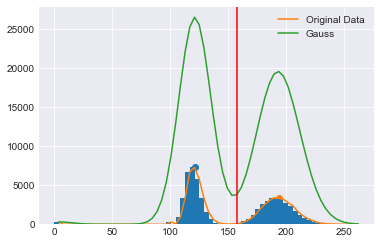

In [221]:
thresholds = {str(int(os.path.splitext(k)[0])): [] for k in os.listdir('data/rawData')}
from scipy import stats
from scipy.signal import find_peaks
from scipy import signal


for dict_ in dicts:
    for file in dict_:
        data = dict_[file]
        plt.figure()
        entries, bin_edges, patches = plt.hist(data,bins=int(max(data)/4))
        x = np.delete(bin_edges,0,0)
        y = entries
        gauss = signal.windows.gaussian(len(x), std=3)
        blurred = signal.fftconvolve(y, gauss, mode='same')
        peaks, _ = find_peaks(blurred)
        plt.scatter(x[peaks[-2:-1]],y[peaks[-2:-1]])
        plt.scatter(x[peaks[-1]],y[peaks[-1]])
        #param, param_cov = curve_fit(two_poisson,x,y, p0=[90,10000,220,5,0.5,60,10000,220,10,0.5])
        plt.plot(x,y,label='Original Data')
        plt.plot(x,blurred,label='Gauss')
        corte = peaks[-2:-1] + int((peaks[-1]-peaks[-2:-1])/2)
        thresholds[file] = x[corte]
        plt.axvline(x[corte],color='red')
        #plt.plot(x,two_poisson(x,param[0],param[1],param[2],param[3],param[4],param[5],param[6],param[7],param[8],param[9]), label =f"Curve Fit Poisson",ls='dashed',color='red') 
        plt.legend()
        #fig.savefig(f'figs/{file}.png')
        #parameters_[file] = param
        
        
        

### Oscilaciones de Rabi

In [207]:
#ESTA DIVISION DE FILES ES LA CORRECTA

In [270]:
#files = {str(os.path.splitext(k)[0]): {} for k in os.listdir('data/rawData')}
files = {}
for i,file in enumerate(os.listdir('data/rawData')):
    name=str(os.path.splitext(file)[0])
    f = open(f'data/rawData/{name}/rawdataEMCCD.dat').read()
    f = f.split('\n')[6:-1]
    f = [i.split('\t')[:-1] for i in f]
    f = np.matrix(f)
    files[str(int(name))]=f
    
#for i in files:
#    print(files[i][0].shape())
        
#np.matrix(files['66'][1]).astype(np.float)



C:\Users\Luna\anaconda3.2\lib\site-packages\numpy\matrixlib\defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = N.array(data, dtype=dtype, copy=copy)


(304, 22)
(304, 102)


<ipython-input-324-1af2ea4396f0>:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  col = np.squeeze(np.asarray(col)).astype(np.float)
<ipython-input-324-1af2ea4396f0>:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  col = np.squeeze(np.asarray(col)).astype(np.float)


(304, 202)


<ipython-input-324-1af2ea4396f0>:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  col = np.squeeze(np.asarray(col)).astype(np.float)


(301, 202)


<ipython-input-324-1af2ea4396f0>:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  col = np.squeeze(np.asarray(col)).astype(np.float)


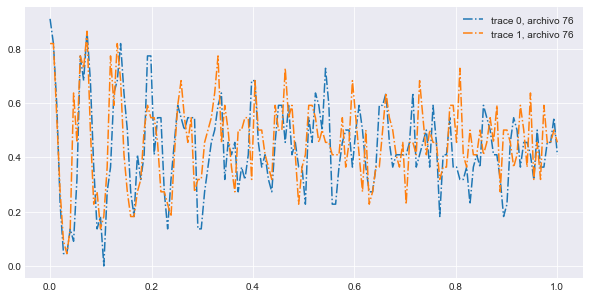

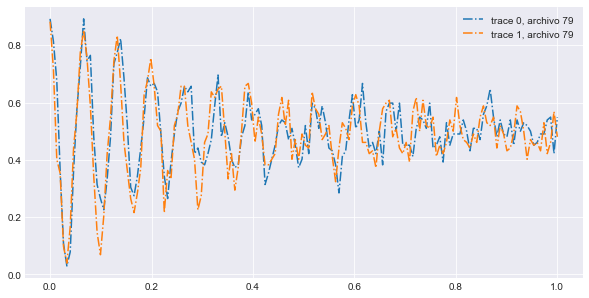

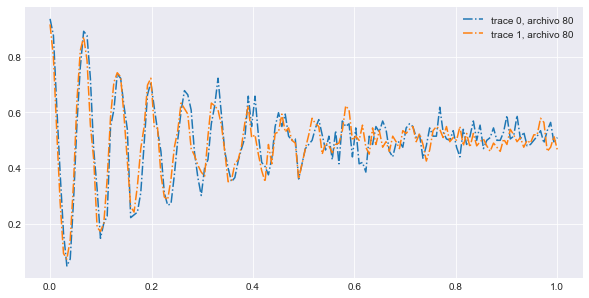

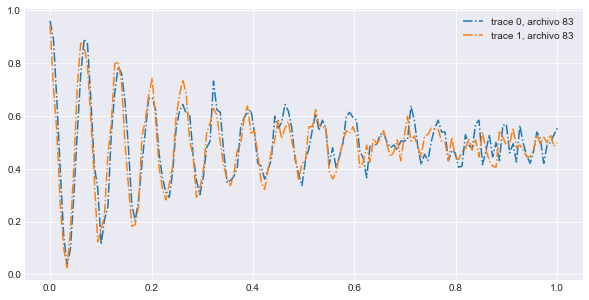

In [324]:
# aca estan las oscilacioens de rabi para TODOS los archivos jajaj
#en este dict voy a guardar los datos de las osc de rabi para los archivos '76', '79', '80', '83'

%matplotlib inline
fs = ['76', '79', '80', '83']
rabi = {f:{'t0': [],'trace_0': [],'t1': [],'trace_1':[]} for f in fs}

for file in ['76', '79', '80', '83']:
    data = files[file]
    trace_0 = []
    trace_1 = []
    
    print(data.shape)
    plt.figure(figsize=(10,5))
    thresh = thresholds[str(int(file))][0] #problema de notacion. arreglar esto
    
    for i,col in enumerate(data):
        col = np.squeeze(np.asarray(col)).astype(np.float)
        N = int(len(col))
        if i % 2 == 0:
            brill = [c for c in col if c>thresh]
            prob_brill = len(brill)/N
            trace_0.append(prob_brill)
        else:
            brill = [c for c in col if c>thresh]
            prob_brill = len(brill)/N
            trace_1.append(prob_brill)
    
    if len(trace_0) % 2 != 0:
        trace_0.pop()
    if len(trace_1) % 2 != 0:
        trace_1.pop()
    t0 = np.linspace(0,1,len(trace_0))
    t1 = np.linspace(0,1,len(trace_1))
    rabi[file]['t0'] = t0
    rabi[file]['t1'] = t1
    rabi[file]['trace_0'] = trace_0
    rabi[file]['trace_1'] = trace_1
    plt.plot(t0,trace_0,label=f'trace 0, archivo {file}',ls='dashdot')
    plt.plot(t1,trace_1,label=f'trace 1, archivo {file}',ls='dashdot')
    plt.legend()
    


$P_g (t) = \frac{1}{2} [ 1 + \sum_{n=0} P_n cos(\Omega_{n,n+1} t)]$

Donde: 

$\Omega_{n,n+s} = \Omega_0 |<n+s| e^{i\eta (a + a^{x})} |n>| = \Omega e^{-\eta^2/2} \eta^{|s|} \sqrt{\frac{n<!}{n>!}} L_{n<}^{|s|}(\eta^2)$

Si s=0:   $\Omega_{n,n} =  \Omega_0 e^{-\eta^2/2} L_{n}^{0}(\eta^2)$

Y

$P_n = \frac{\bar{n}^{n}}{(\bar{n} + 1)^{n+1}}$



$P_g (t) = \frac{1}{2} [ 1 + P_0 cos(\Omega_{0,1} t) + P_1 cos(\Omega_{1,2} t)] = \frac{1}{2} [ 1 + \frac{1}{(\bar{n} + 1)} cos( \Omega_0 e^{-\eta^2/2} L_{0}(\eta^2) t) + \frac{\bar{n}}{(\bar{n} + 1)^{2}} cos( \Omega_0 e^{-\eta^2/2} L_{1}(\eta^2) t)] $

### Fitteo los trace 0 (Doppler)

Parameters([('omega', <Parameter 'omega', value=-inf, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=-inf, bounds=[-inf:inf]>), ('amplitud', <Parameter 'amplitud', value=-inf, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=-inf, bounds=[-inf:inf]>), ('h', <Parameter 'h', value=-inf, bounds=[-inf:inf]>)])
[[Model]]
    Model(RabiModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 154
    # data points      = 152
    # variables        = 5
    chi-square         = 2.14241122
    reduced chi-square = 0.01457423
    Akaike info crit   = -637.816186
    Bayesian info crit = -622.696783
[[Variables]]
    omega:     95.1100921 +/- 0.42783244 (0.45%) (init = 90)
    gamma:     2.62055698 +/- 204.566235 (7806.21%) (init = 5)
    amplitud:  2.4392e-05 +/- 174.889865 (716997623.19%) (init = 2)
    b:        -0.85482381 +/- 0.08889962 (10.40%) (init = 3)
    h:         2.93139142 +/- 0.11087432 (3.78%) (init = 3)
[[Correlations]] (unreported correlations

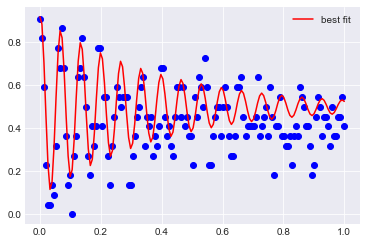

Parameters([('omega', <Parameter 'omega', value=-inf, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=-inf, bounds=[-inf:inf]>), ('amplitud', <Parameter 'amplitud', value=-inf, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=-inf, bounds=[-inf:inf]>), ('h', <Parameter 'h', value=-inf, bounds=[-inf:inf]>)])
[[Model]]
    Model(RabiModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 179
    # data points      = 152
    # variables        = 5
    chi-square         = 0.45427633
    reduced chi-square = 0.00309032
    Akaike info crit   = -873.565381
    Bayesian info crit = -858.445979
[[Variables]]
    omega:     94.4483487 +/- 0.27895425 (0.30%) (init = 90)
    gamma:     3.54203932 +/- 1065.55899 (30083.21%) (init = 5)
    amplitud:  9.1836e-05 +/- 311.683068 (339390033.36%) (init = 2)
    b:        -0.88978131 +/- 0.05452909 (6.13%) (init = 3)
    h:         3.04147267 +/- 0.05516411 (1.81%) (init = 3)
[[Correlations]] (unreported correlations

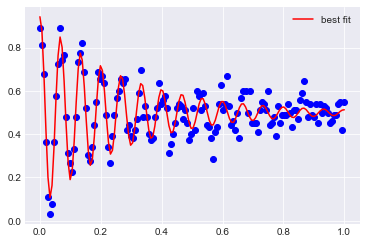

Parameters([('omega', <Parameter 'omega', value=-inf, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=-inf, bounds=[-inf:inf]>), ('amplitud', <Parameter 'amplitud', value=-inf, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=-inf, bounds=[-inf:inf]>), ('h', <Parameter 'h', value=-inf, bounds=[-inf:inf]>)])
[[Model]]
    Model(RabiModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 127
    # data points      = 152
    # variables        = 5
    chi-square         = 0.32319205
    reduced chi-square = 0.00219859
    Akaike info crit   = -925.315141
    Bayesian info crit = -910.195738
[[Variables]]
    omega:     95.8765340 +/- 0.25364198 (0.26%) (init = 90)
    gamma:     2.04255439 +/- 0.37064394 (18.15%) (init = 5)
    amplitud:  1.06419977 +/- 0.12315113 (11.57%) (init = 2)
    b:        -0.93230668 +/- 0.04059670 (4.35%) (init = 3)
    h:         2.86144624 +/- 0.04595208 (1.61%) (init = 3)
[[Correlations]] (unreported correlations are < 0.1

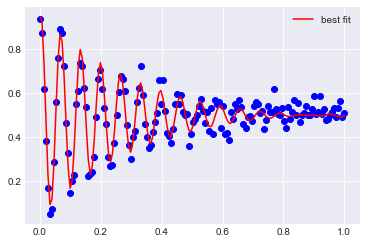

Parameters([('omega', <Parameter 'omega', value=-inf, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=-inf, bounds=[-inf:inf]>), ('amplitud', <Parameter 'amplitud', value=-inf, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=-inf, bounds=[-inf:inf]>), ('h', <Parameter 'h', value=-inf, bounds=[-inf:inf]>)])
[[Model]]
    Model(RabiModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 145
    # data points      = 150
    # variables        = 5
    chi-square         = 0.40251847
    reduced chi-square = 0.00277599
    Akaike info crit   = -878.097440
    Bayesian info crit = -863.044263
[[Variables]]
    omega:     96.7020739 +/- 0.24875641 (0.26%) (init = 90)
    gamma:     2.23883194 +/- 0.61996124 (27.69%) (init = 5)
    amplitud:  0.79885690 +/- 0.26986583 (33.78%) (init = 2)
    b:        -0.92601705 +/- 0.04683050 (5.06%) (init = 3)
    h:         2.77074023 +/- 0.04997890 (1.80%) (init = 3)
[[Correlations]] (unreported correlations are < 0.1

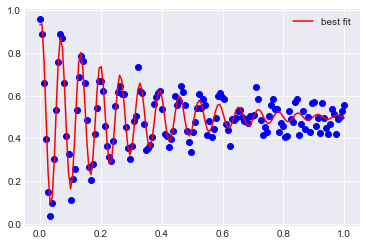

In [326]:
%matplotlib inline
from lmfit import Model


def RabiModel(t,omega,gamma,amplitud,b,h):
    t1 = (amplitud * t + b)* np.cos(omega * t + h) * np.exp(-(gamma*t))
    return 1/2*(1+t1)

for f in fs:
    mod = Model(RabiModel)   
    pars = mod.make_params()
    print(pars)
    #pars['omega1'].set(60,min = 0)
    pars['omega'].set(90,min = 0)
    pars['gamma'].set(5, min=0)
    pars['amplitud'].set(2,min = 0)
    pars['b'].set(3)
    pars['h'].set(3)
    
    x = rabi[f]['t0']
    y = rabi[f]['trace_0']
    result = mod.fit(y, pars, t=x)

    print(result.fit_report())
    plt.figure()
    plt.plot(x, y, 'bo')
    #plt.plot(t0, result.init_fit, 'k--', label='initial fit')
    plt.plot(x, result.best_fit, 'r-', label='best fit')
    plt.legend(loc='best')
    plt.show()

### Trial con un archivo solo (previo)

### 83: enfriamiento doppler

In [258]:
import numpy as np
f= open(f'data/rawData/83/rawdataEMCCD.dat').read()
#f = np.transpose(np.loadtxt('data/simple/RabiOsc_SBC_carrier_tobs=2ms.dat', delimiter=' '))
f = f.split('\n')[6:-1]
f = [i.split('\t')[:-1] for i in f]
f = np.matrix(f).astype(np.float)
f.shape
#f = np.transpose(f)

<ipython-input-258-2663535e14bb>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  f = np.matrix(f).astype(np.float)


(301, 202)

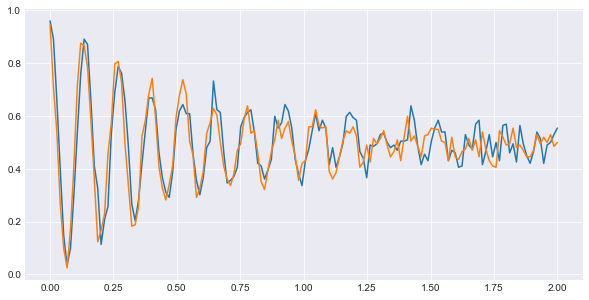

In [259]:
trace_0 = []
trace_1 = []
t = np.linspace(0,2,150)

plt.figure(figsize=(10,5))
thresh = thresholds['83'][0]
for i,col in enumerate(f):
    col = np.squeeze(np.asarray(col))
    N = int(len(col))
    if i % 2 == 0:
        
        brill = [c for c in col if c>thresh]
        prob_brill = len(brill)/N
        trace_0.append(prob_brill)
    else:
        brill = [c for c in col if c>thresh]
        prob_brill = len(brill)/N
        trace_1.append(prob_brill)
        
trace_0.pop()
plt.plot(t,trace_0)
plt.plot(t,trace_1)

Parameters([('omega', <Parameter 'omega', value=-inf, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=-inf, bounds=[-inf:inf]>), ('amplitud', <Parameter 'amplitud', value=-inf, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=-inf, bounds=[-inf:inf]>), ('h', <Parameter 'h', value=-inf, bounds=[-inf:inf]>)])
[[Model]]
    Model(RabiModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 145
    # data points      = 150
    # variables        = 5
    chi-square         = 0.40251847
    reduced chi-square = 0.00277599
    Akaike info crit   = -878.097440
    Bayesian info crit = -863.044263
[[Variables]]
    omega:     96.7020739 +/- 0.24875641 (0.26%) (init = 90)
    gamma:     2.23883194 +/- 0.61996124 (27.69%) (init = 5)
    amplitud:  0.79885690 +/- 0.26986583 (33.78%) (init = 2)
    b:        -0.92601705 +/- 0.04683050 (5.06%) (init = 3)
    h:         2.77074023 +/- 0.04997890 (1.80%) (init = 3)
[[Correlations]] (unreported correlations are < 0.1

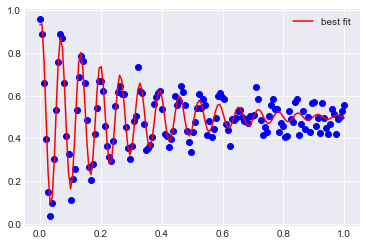

In [325]:
%matplotlib inline
from lmfit import Model

    
def RabiModel(t,omega,gamma,amplitud,b,h):
    t1 = (amplitud * t + b)* np.cos(omega * t + h) * np.exp(-(gamma*t))
    return 1/2*(1+t1)
 
mod = Model(RabiModel)   
pars = mod.make_params()
print(pars)
#pars['omega1'].set(60,min = 0)
pars['omega'].set(90,min = 0)
pars['gamma'].set(5, min=0)
pars['amplitud'].set(2,min = 0)
pars['b'].set(3)
pars['h'].set(3)

result = mod.fit(trace_0, pars, t=t0)

print(result.fit_report())
plt.figure()
plt.plot(t0, trace_0, 'bo')
#plt.plot(t0, result.init_fit, 'k--', label='initial fit')
plt.plot(t0, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()